In [78]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import glob
import scipy.stats as stats
import seaborn as sns

from scipy.stats import f_oneway
from scipy.stats import ttest_ind
from scipy.stats import zscore
from statsmodels.stats.multicomp import MultiComparison

from hmmlearn import hmm
from matplotlib import rcParams


Behav = ["Walking", "Sniffing", "Immobile", "Rearing", "Grooming"]
behav_num = len(Behav)
label_num = 20

def SE(data):
    return np.std(data)/np.sqrt(np.size(data))

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

### Data load

In [92]:
############################# Load A-SOiD annotated behavior data, stimulation data from .npy data ############################
# 0:Walking, 1:Sniffing, 2:Immobile, 3:Rearing, 4:Face Grooming, 5:Body Grooming

start_time = 300 # Omit the first 10 sec

GFAP_behavs = [np.load(f"Openfield_Asoidoutput/GFAP_mouse{i+1}_behav.npy").astype(int)[start_time:] for i in range(5)]
GFAP_stims = [np.load(f"Openfield_stimulation/GFAP_mouse{i+1}_stim.npy")[start_time:]for i in range(5)]

In [93]:
############################ Merge body grooming and face grooming into grooming ###########################
for i in range(5):
    GFAP_behavs[i][GFAP_behavs[i]==5] = 4

In [94]:
############################# Load B-SOiD clustered behavior data ############################
# GFAP_bsoidbout_files = glob.glob("Openfield_Bsoidoutput/*bout_length*.csv")
# GFAP_bsoidbout_files.sort()
# GFAP_bsoidbout_files = np.array(GFAP_bsoidbout_files)[[0,2,3,4,6]]

GFAP_bsoidlabel_files = glob.glob("Openfield_Bsoidoutput/*labels_pose*.csv")
GFAP_bsoidlabel_files.sort()
GFAP_bsoidlabel_files = np.array(GFAP_bsoidlabel_files)[[0,2,3,4,6]]

# GFAP_bsoidtrans_files = glob.glob("Openfield_Bsoidoutput/*transitions_mat*.csv")
# GFAP_bsoidtrans_files.sort()
# GFAP_bsoidtrans_files = np.array(GFAP_bsoidtrans_files)[[0,2,3,4,6]]

GFAP_bsoidlabels = [pd.read_csv(GFAP_bsoidlabel_files[i])["B-SOiD labels"].to_numpy().astype(int)[start_time+2:] for i in range(5)]
# GFAP_bsoidtrans = [pd.read_csv(GFAP_bsoidtrans_files[i]).to_numpy() for i in range(5)]

## Stimulation Effect on Behavioral Trend
* post-stimulation period still have effect of stimulation.
* Excluded the post-8sec period from stim-off period.

In [95]:
## return the normalized count of each behavioral counts.

def behav_dist(behav, stim, behav_num):
    # Behavior Distribution
    unique_behaviors, behavior_counts = np.unique(behav, return_counts=True)
    behavior_distribution = dict(zip(unique_behaviors, behavior_counts))
    
    switch_mask = np.zeros_like(stim, dtype=bool)
    for i in range(len(stim) - 1):
        if ~stim[i] and stim[i+1]: ## Detect the stim-of timing (False->True)
            switch_mask[max(i + 1, 0):min(i + 241, len(stim))] = True
            
    # Adjust stim to include only the relevant periods
    stim = np.where(switch_mask, False, stim)  # Set switch periods to False (switch post 8sec period as stim-on)
    
    # Initializing dictionaries to hold behavior counts during stimulation and no stimulation
    behavior_counts_stimulation = {i: 0 for i in range(behav_num)}
    behavior_counts_no_stimulation = {i: 0 for i in range(behav_num)}
    
    # Counting occurrences of each behavior during stimulation and no stimulation periods
    for behavior in range(behav_num):
        behavior_mask = behav == behavior
        stim_mask = (stim == False)  # Stim-on periods, excluding nans
        no_stim_mask = (stim == True)  # Stim-off periods, excluding nans
        
        # Count occurrences for each condition, normalized by the total counts, excluding nans
        behavior_counts_stimulation[behavior] = np.sum(behavior_mask & stim_mask) / np.sum(stim_mask) * 100
        behavior_counts_no_stimulation[behavior] = np.sum(behavior_mask & no_stim_mask) / np.sum(no_stim_mask) * 100
    
    return [behavior_counts_stimulation, behavior_counts_no_stimulation]

Walking TtestResult(statistic=0.33586841451674004, pvalue=0.746031279389006, df=7.619115875341632)
Sniffing TtestResult(statistic=0.2589486351276542, pvalue=0.8025028567508093, df=7.653284541596691)
Immobile TtestResult(statistic=-0.9025960268853555, pvalue=0.403100014761853, df=5.727688737013636)
Rearing TtestResult(statistic=-0.4516548713037283, pvalue=0.6642184955581594, df=7.543815177192333)
Grooming TtestResult(statistic=-0.7616758165923818, pvalue=0.47249898354956066, df=6.622707427086164)


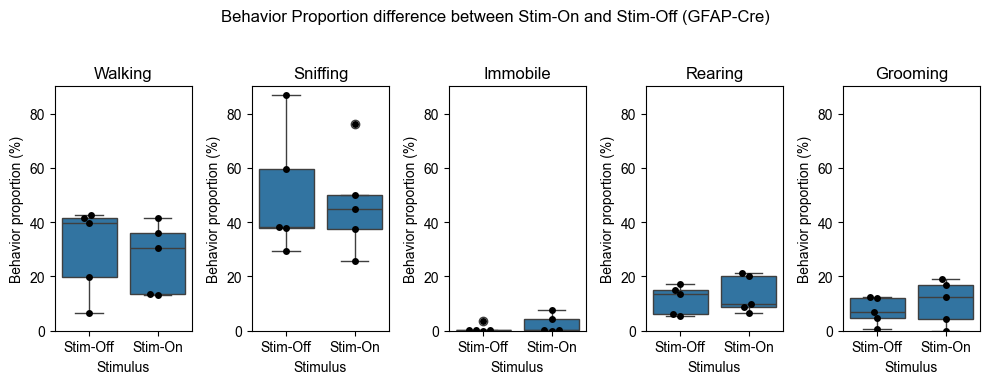

In [96]:
##################### A-SOiD #####################
## GFAP

behav_dist_stim = [behav_dist(GFAP_behavs[i], GFAP_stims[i], behav_num) for i in range(5)]

fig, axs = plt.subplots(1, 5, figsize=(10,4))
fig.suptitle('Behavior Proportion difference between Stim-On and Stim-Off (GFAP-Cre)')

stim_on_avgs = []
stim_off_avgs = []
for i, ax in enumerate(axs.flatten()):
    if i >= behav_num:
        continue 
    stim_on_avgs = [dist[0][i] for dist in behav_dist_stim]
    stim_off_avgs = [dist[1][i] for dist in behav_dist_stim]

    # ax.bar(['Stim-Off', 'Stim-On'],
    #        [np.mean(stim_off_avgs), np.mean(stim_on_avgs)],
    #        yerr = [SE(stim_off_avgs), SE(stim_on_avgs)])
    # Prepare data for swarmplot
    data = stim_off_avgs + stim_on_avgs
    labels = ['Stim-Off'] * len(stim_off_avgs) + ['Stim-On'] * len(stim_on_avgs)

    # Convert data to DataFrame for seaborn
    df = pd.DataFrame({
        'Behavior proportion (%)': data,
        'Stimulus': labels
    })

    # Plot boxplot
    sns.boxplot(x='Stimulus', y='Behavior proportion (%)', data=df, ax=ax)

    # Plot swarmplot on top of the boxplot
    sns.swarmplot(x='Stimulus', y='Behavior proportion (%)', data=df, ax=ax, color='black')

    # Plot swarmplot on top of the boxplot
    ax.set_title(Behav[i])
    ax.set_ylabel('Behavior proportion (%)')
    ax.set_ylim(0,90)

    rcParams['pdf.fonttype'] = 42
    rcParams['font.family'] = 'Arial' 

    #### T-test #######
    t_test_result = stats.ttest_ind(stim_off_avgs, stim_on_avgs, equal_var=False)  # Using Welch's t-test
    print(Behav[i], t_test_result)
 
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("/Users/hirokane/Python/GFAP_opto_openfield_Iakovos/Figure2K.pdf")
plt.show()

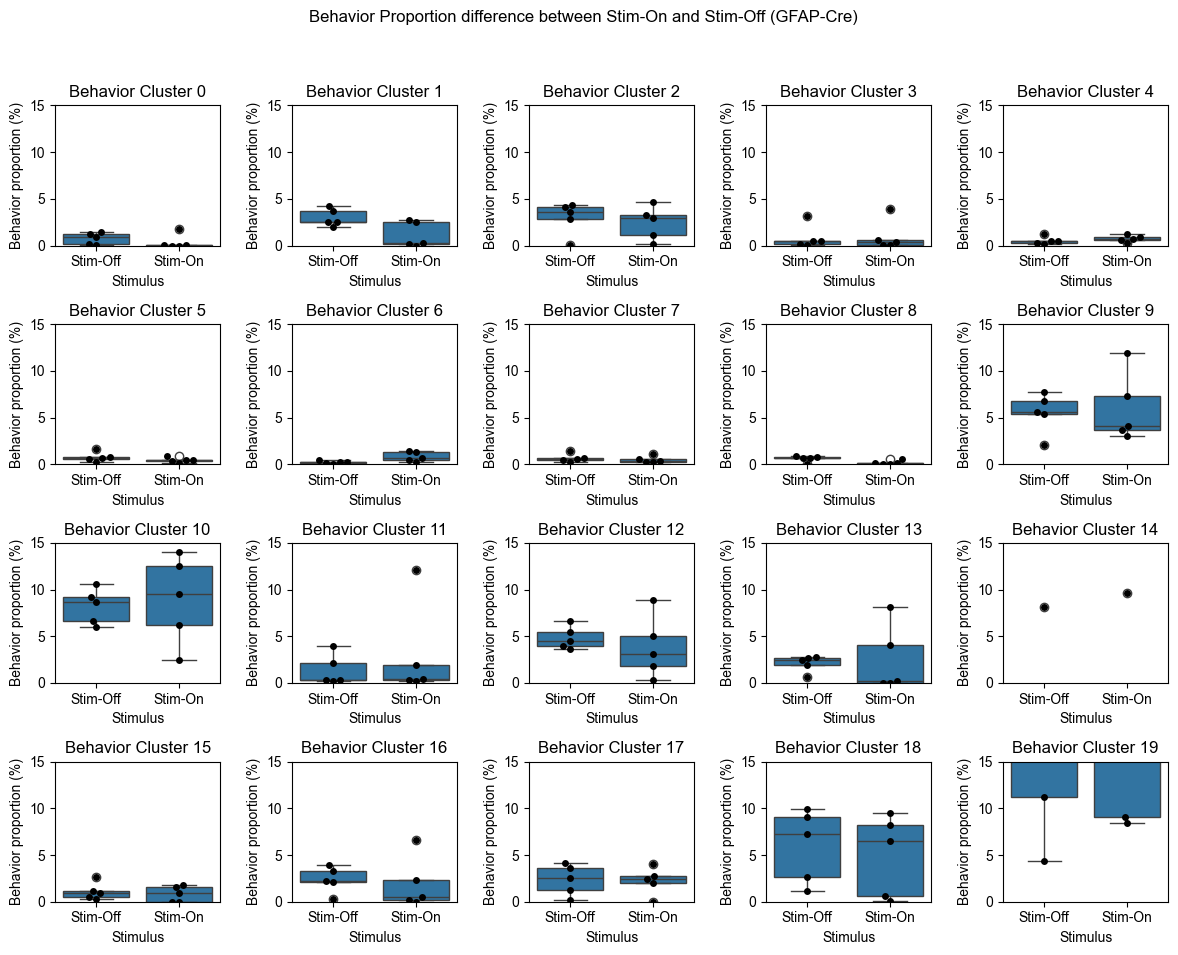

In [124]:
behav_dist_stim_GFAP = [behav_dist(GFAP_bsoidlabels[i], GFAP_stims[i], 34) for i in range(5)]

fig, axs = plt.subplots(4, 5, figsize=(12,10))
fig.suptitle('Behavior Proportion difference between Stim-On and Stim-Off (GFAP-Cre)')

stim_on_avgs_GFAP = []
stim_off_avgs_GFAP = []
for i, ax in enumerate(axs.flatten()):
    stim_on_avgs_GFAP = [dist[0][i+14] for dist in behav_dist_stim_GFAP]
    stim_off_avgs_GFAP = [dist[1][i+14] for dist in behav_dist_stim_GFAP]

    # Plotting
    # ax.bar(['Stim-Off', 'Stim-On'],
    #        [np.mean(stim_off_avgs_GFAP), np.mean(stim_on_avgs_GFAP)],
    #        yerr = [SE(stim_off_avgs_GFAP), SE(stim_on_avgs_GFAP)])
    data = stim_off_avgs_GFAP + stim_on_avgs_GFAP
    labels = ['Stim-Off'] * len(stim_off_avgs_GFAP) + ['Stim-On'] * len(stim_on_avgs_GFAP)

    # Convert data to DataFrame for seaborn
    df = pd.DataFrame({
        'Behavior proportion (%)': data,
        'Stimulus': labels
    })

    # Plot boxplot
    sns.boxplot(x='Stimulus', y='Behavior proportion (%)', data=df, ax=ax)

    # Plot swarmplot on top of the boxplot
    sns.swarmplot(x='Stimulus', y='Behavior proportion (%)', data=df, ax=ax, color='black')
    
    ax.set_title(f"Behavior Cluster {i}")
    ax.set_ylabel('Behavior proportion (%)')
    ax.set_ylim(0,15)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

/Users/hirokane/anaconda3/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/var/folders/z7/s77cy2p96jg2dp0synyyllsm0000gn/T/ipykernel_2722/3118966701.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(sorted_indices)
/var/folders/z7/s77cy2p96jg2dp0synyyllsm0000gn/T/ipykernel_2722/3118966701.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


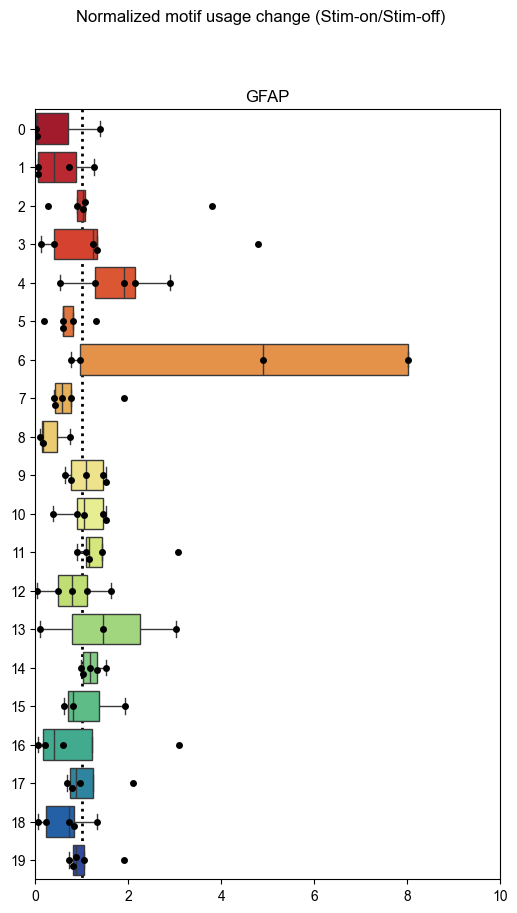

In [127]:
# ratio_GFAP = [[] for i in range(label_num)]
ratio_GFAP = [np.full(5, np.nan) for _ in range(label_num)]
for i in range(5):
    for j in range(label_num):
        stim_on = behav_dist_stim_GFAP[i][0][j+14]
        stim_off = behav_dist_stim_GFAP[i][1][j+14]
        if stim_on==0 or stim_off==0:
            continue
        else:
            ratio_GFAP[j][i] = stim_on/stim_off

ratio_GFAP = np.array(ratio_GFAP)

medians_GFAP = np.nanmean(ratio_GFAP, axis=1)

# sorted_indices = np.argsort(-medians_GFAP)
sorted_indices = np.arange(label_num)
sorted_ratio_GFAP = ratio_GFAP[sorted_indices]

colors = sns.color_palette("Spectral", n_colors=20)
for i in range(label_num):
    max_color = max(colors[i][0], colors[i][1], colors[i][2])
    max_color2 = max(colors[i][0]**2, colors[i][1]**2, colors[i][2]**2)
    ratio = max_color/max_color2
    colors[i] = (colors[i][0]**2*ratio, colors[i][1]**2*ratio, colors[i][2]**2*ratio)
sorted_colors = [colors[i] for i in sorted_indices]

fig, ax = plt.subplots(1,1,figsize=(6,10))
fig.suptitle("Normalized motif usage change (Stim-on/Stim-off)")
positions = np.arange(sorted_ratio_GFAP.shape[0])

# ax[0].violinplot(ratio_GFAP, positions=positions, widths=0.5, vert=False)
ax.vlines(1, -0.5, 32.5, color="k", linewidth=2, linestyles="dotted")
sns.boxplot(sorted_ratio_GFAP.T, ax=ax, orient="h", fliersize=0, palette=sorted_colors)
sns.swarmplot(sorted_ratio_GFAP.T, ax=ax, orient="h", color="k")
ax.set_title("GFAP")
ax.set_xlim([0,10])
ax.set_yticklabels(sorted_indices)
# for y1 in [0,16,17,19]: # 1,7,9,19
#     ax[0].text(x=4.5, y=y1+0.28, s="*", fontsize=18)

fig.show()
#fig.savefig("figure1.svg", format="svg")